In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
current_env = "local"

if current_env == "local":
    data_path = "../ump-dataset"

elif current_env == "kaggle":
    data_path = "../input/ump-dataset"
    
elif current_env == "colab":
    pass

print("data_path:", data_path)

data_path: ../ump-dataset


***
## loading data

In [3]:
features = [f"f_{i}" for i in range(300)]

features = pd.read_parquet(f"{data_path}/train.parquet", columns=features)
display(features)

target = pd.read_parquet(f"{data_path}/train.parquet", columns=["target",])
display(target)

time = pd.read_parquet(f"{data_path}/train.parquet", columns=["time_id",])
display(time)

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,0.965623,1.230508,0.114809,-2.012777,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,1.428127,1.134144,0.114809,-0.219201,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,0.979656,-1.125681,0.114809,-1.035376,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,0.778096,0.298990,0.114809,-1.176410,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,-0.946789,1.230508,0.114809,-0.005858,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141405,0.093530,-0.720275,-0.345497,-0.438781,-0.166972,-0.437182,1.475746,1.284423,0.056425,-1.433681,...,-0.285908,-1.232434,-0.660579,0.875537,0.421628,-0.428097,-0.075548,-0.533092,-0.193732,-0.581394
3141406,-1.344935,-0.199987,-0.107702,-0.454677,-0.221914,-0.141174,-1.498235,1.373834,0.056425,-1.211572,...,0.184517,-1.232434,-0.670493,0.875537,0.421628,-0.729949,-1.514277,0.013145,-0.890270,-0.589705
3141407,0.979489,-1.110491,1.006980,-0.467307,-0.159549,1.355671,0.150812,-0.088923,0.056425,0.996380,...,-0.756332,-1.232434,0.820784,-1.142157,0.421628,-0.363329,1.363181,-0.079106,-1.580124,-0.297625
3141408,-2.565332,0.320301,0.076600,1.380182,-0.155366,-0.689000,0.381069,-1.324759,0.056425,-1.111730,...,-0.756332,-1.232434,0.133074,-1.142157,0.421628,-0.375288,-1.514277,-0.973762,0.608647,-0.372040


,target
0,-0.300875
1,-0.231040
2,0.568807
3,-1.064780
4,-0.531940
...,...
3141405,0.033600
3141406,-0.223264
3141407,-0.559415
3141408,0.009599


,time_id
0,0
1,0
2,0
3,0
4,0
...,...
3141405,1219
3141406,1219
3141407,1219
3141408,1219


In [4]:
time_ids = np.sort(time.time_id.unique())
len(time_ids)

1211

In [5]:
n_time_steps = len(time_ids)
print("time steps:", n_time_steps)

valid_prop = 0.1
valid_size = int(0.1 * n_time_steps)
print("valid size:", valid_size)

time steps: 1211
valid size: 121


In [6]:
# train-valid splits
n_splits = 3
end_idx = n_time_steps 

splits = list()

for start_idx in np.arange(1211, 0, -valid_size)[1:n_splits+1]:
    valid_time_ids = time_ids[start_idx:end_idx]
    train_time_end = time_ids[start_idx]-1
    end_idx = start_idx
    
    train_idx = time.query("time_id <= @train_time_end").index
    valid_idx = time.query("time_id in @valid_time_ids").index
    splits.append((train_idx,valid_idx))

In [7]:
import gc
gc.collect()

231

***
## model training: finding number of iterations

In [10]:
def pearsonr(preds: np.array, dset: lgb.Dataset):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: LightGBM dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0], True

In [11]:
model_params = {
    'boosting': 'dart',
    'drop_rate': 0.1,
    'max_drop': 20,
    'skip_drop': 0.66,

    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 55,
    'learning_rate': 0.05,
    'feature_fraction': 0.616,
    'bagging_fraction': 0.8,
    'force_col_wise': True,
    'feature_pre_filter': False,
    'lambda_l1': 3.563444727371679,
    'lambda_l2': 0.30026771722107604,
    'bagging_freq': 0,
    'min_child_samples': 100,
}

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2740634, number of used features: 300
[LightGBM] [Info] Start training from score -0.022338


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[20]	valid_0's rmse: 0.899348	valid_0's pearsonr: 0.122949
[40]	valid_0's rmse: 0.897647	valid_0's pearsonr: 0.127794
[60]	valid_0's rmse: 0.897332	valid_0's pearsonr: 0.128362
[80]	valid_0's rmse: 0.897059	valid_0's pearsonr: 0.128628
[100]	valid_0's rmse: 0.896688	valid_0's pearsonr: 0.129713
[120]	valid_0's rmse: 0.896597	valid_0's pearsonr: 0.130178
[140]	valid_0's rmse: 0.896203	valid_0's pearsonr: 0.131665
[160]	valid_0's rmse: 0.896068	valid_0's pearsonr: 0.133149
[180]	valid_0's rmse: 0.895921	valid_0's pearsonr: 0.133835
[200]	valid_0's rmse: 0.895794	valid_0's pearsonr: 0.133706
[220]	valid_0's rmse: 0.895646	valid_0's pearsonr: 0.134258
[240]	valid_0's rmse: 0.895543	valid_0's pearsonr: 0.134561
[260]	valid_0's rmse: 0.895569	valid_0's pearsonr: 0.134869
[280]	valid_0's rmse: 0.895439	valid_0's pearsonr: 0.135811
[300]	valid_0's rmse: 0.895405	valid_0's pearsonr: 0.135568
[320]	valid_0's rmse: 0.895294	valid_0's pearsonr: 0.136344
[340]	valid_0's rmse: 0.895252	valid_0's pea

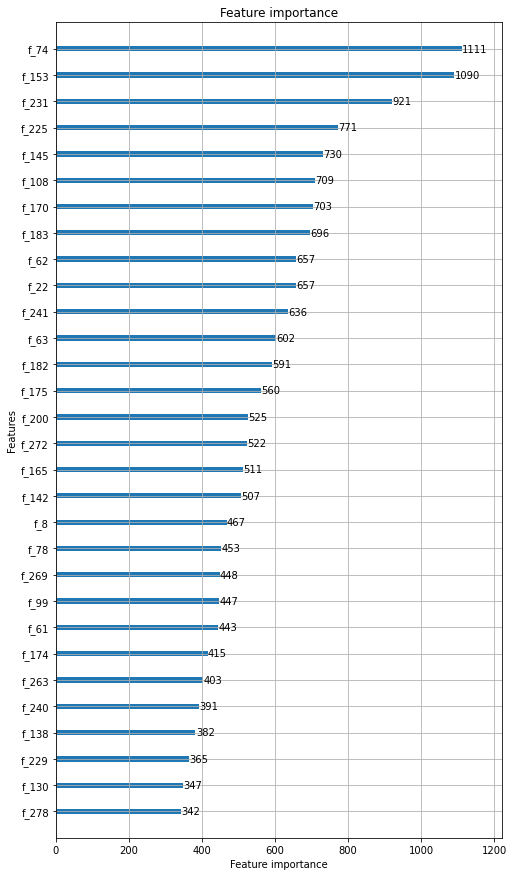

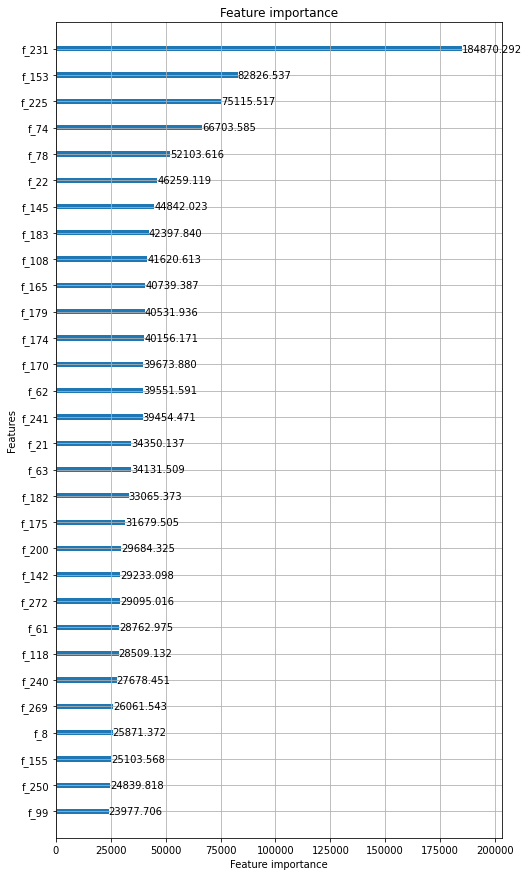

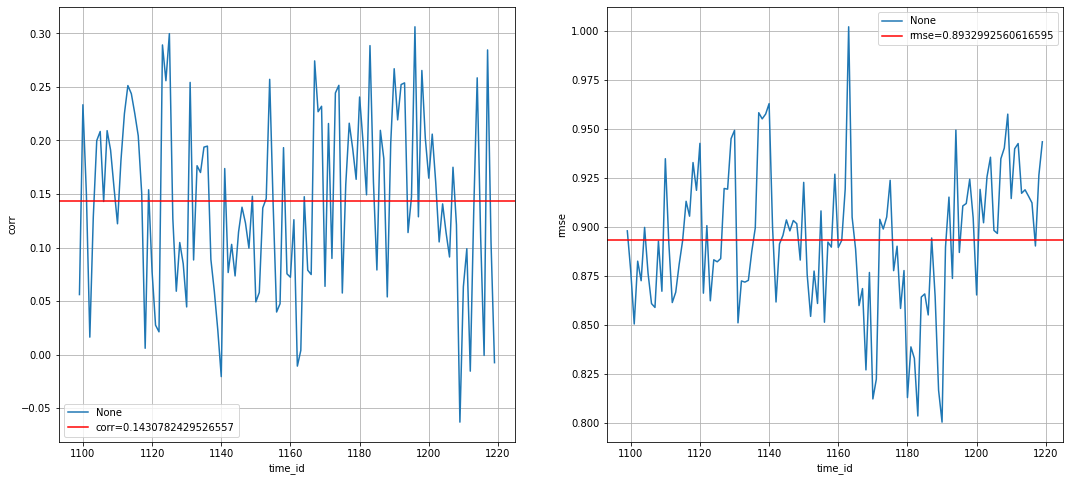

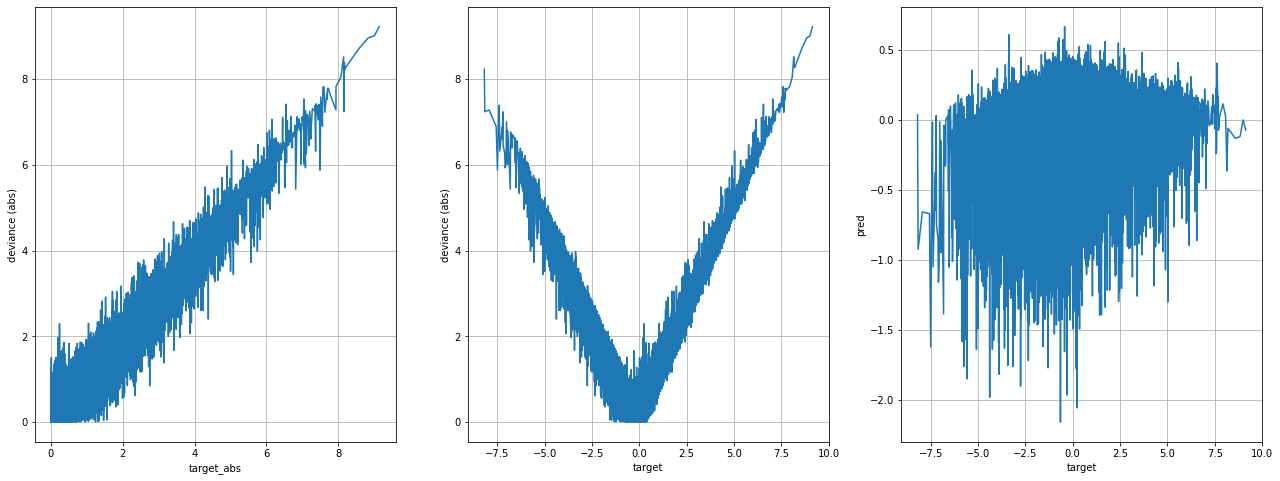

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2364296, number of used features: 300
[LightGBM] [Info] Start training from score -0.024609


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[20]	valid_0's rmse: 0.906954	valid_0's pearsonr: 0.107685
[40]	valid_0's rmse: 0.90566	valid_0's pearsonr: 0.111381
[60]	valid_0's rmse: 0.9052	valid_0's pearsonr: 0.114706
[80]	valid_0's rmse: 0.904781	valid_0's pearsonr: 0.118264
[100]	valid_0's rmse: 0.904392	valid_0's pearsonr: 0.120419
[120]	valid_0's rmse: 0.904149	valid_0's pearsonr: 0.123121
[140]	valid_0's rmse: 0.903834	valid_0's pearsonr: 0.124312
[160]	valid_0's rmse: 0.903728	valid_0's pearsonr: 0.125493
[180]	valid_0's rmse: 0.903525	valid_0's pearsonr: 0.127213
[200]	valid_0's rmse: 0.90333	valid_0's pearsonr: 0.128072
[220]	valid_0's rmse: 0.903147	valid_0's pearsonr: 0.129386
[240]	valid_0's rmse: 0.902973	valid_0's pearsonr: 0.130325
[260]	valid_0's rmse: 0.90296	valid_0's pearsonr: 0.131042
[280]	valid_0's rmse: 0.902882	valid_0's pearsonr: 0.131542
[300]	valid_0's rmse: 0.90276	valid_0's pearsonr: 0.132038
[320]	valid_0's rmse: 0.902712	valid_0's pearsonr: 0.13222
[340]	valid_0's rmse: 0.902533	valid_0's pearsonr: 

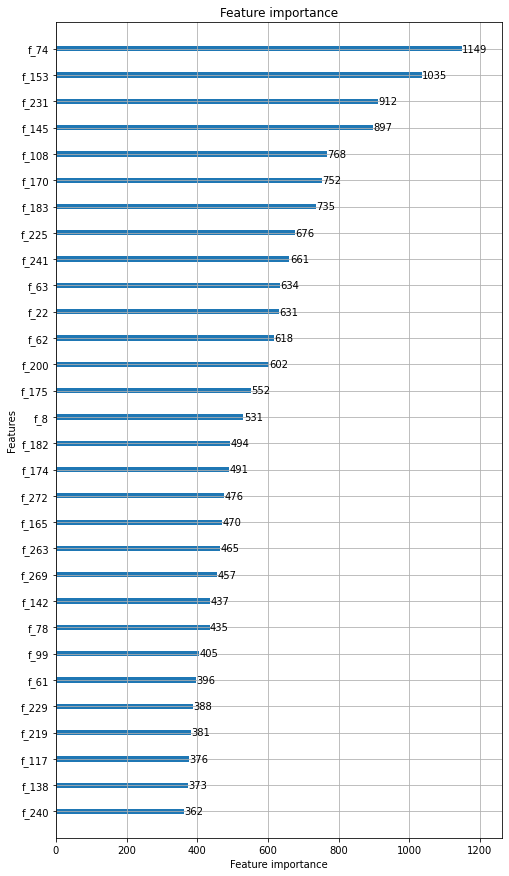

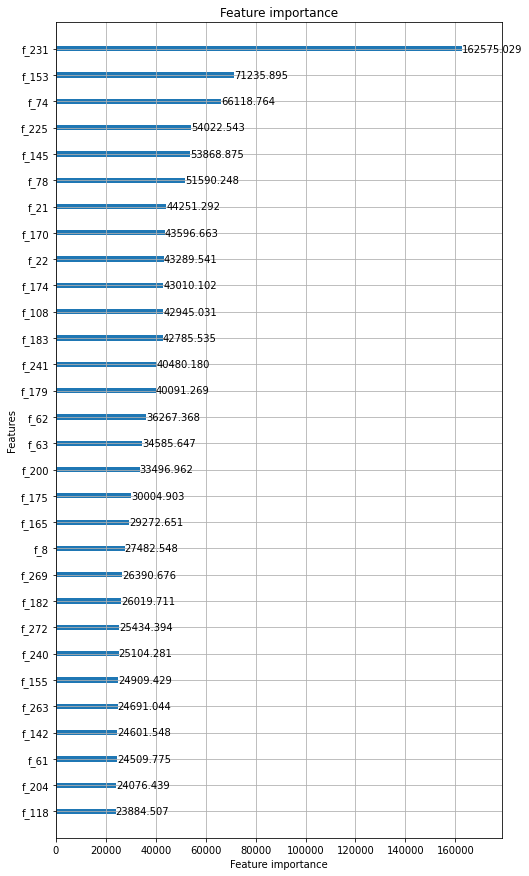

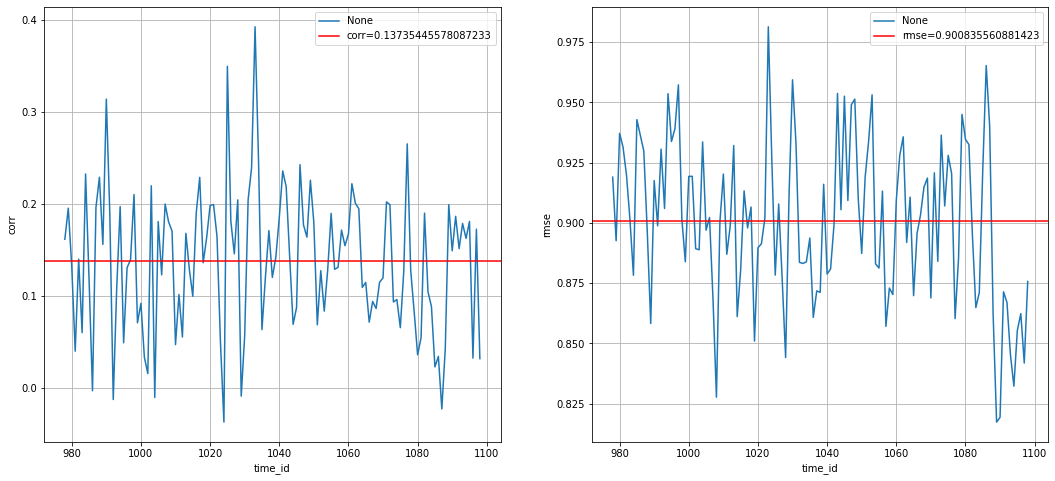

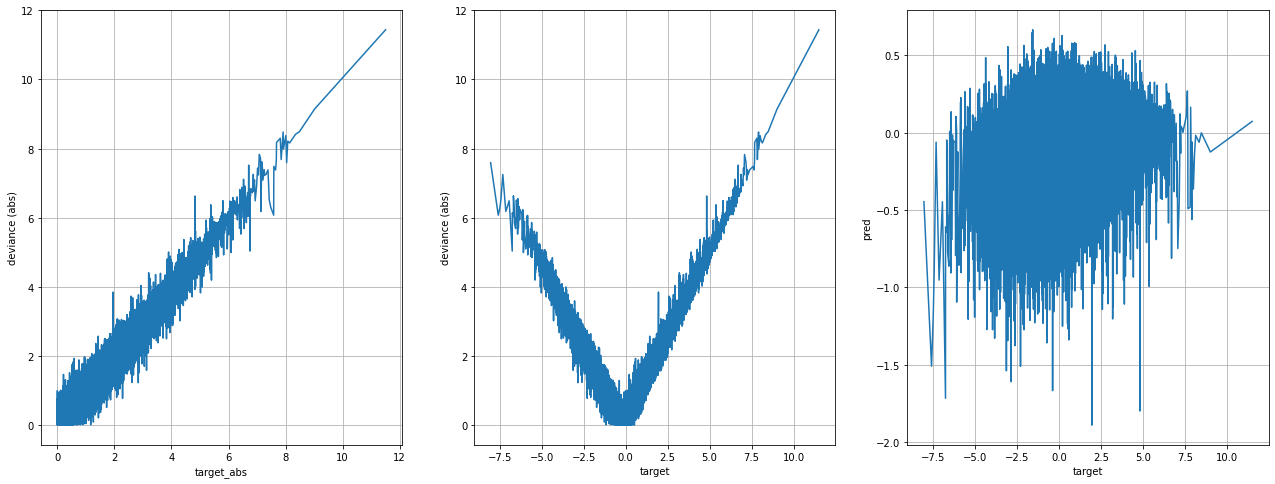

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1995404, number of used features: 300
[LightGBM] [Info] Start training from score -0.026871


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[20]	valid_0's rmse: 0.941018	valid_0's pearsonr: 0.0924261
[40]	valid_0's rmse: 0.939942	valid_0's pearsonr: 0.0976103
[60]	valid_0's rmse: 0.939551	valid_0's pearsonr: 0.100955
[80]	valid_0's rmse: 0.939228	valid_0's pearsonr: 0.104359
[100]	valid_0's rmse: 0.938909	valid_0's pearsonr: 0.106391
[120]	valid_0's rmse: 0.938726	valid_0's pearsonr: 0.108332
[140]	valid_0's rmse: 0.938418	valid_0's pearsonr: 0.110441
[160]	valid_0's rmse: 0.938283	valid_0's pearsonr: 0.112066
[180]	valid_0's rmse: 0.938115	valid_0's pearsonr: 0.113415
[200]	valid_0's rmse: 0.937915	valid_0's pearsonr: 0.114841
[220]	valid_0's rmse: 0.937743	valid_0's pearsonr: 0.116107
[240]	valid_0's rmse: 0.937531	valid_0's pearsonr: 0.117979
[260]	valid_0's rmse: 0.937541	valid_0's pearsonr: 0.118205
[280]	valid_0's rmse: 0.93742	valid_0's pearsonr: 0.119258
[300]	valid_0's rmse: 0.937324	valid_0's pearsonr: 0.119819
[320]	valid_0's rmse: 0.937248	valid_0's pearsonr: 0.12036
[340]	valid_0's rmse: 0.937116	valid_0's pea

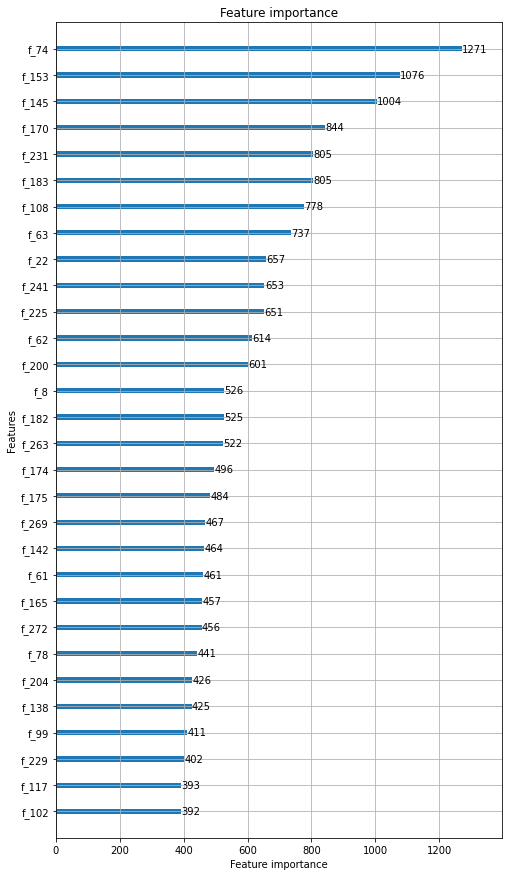

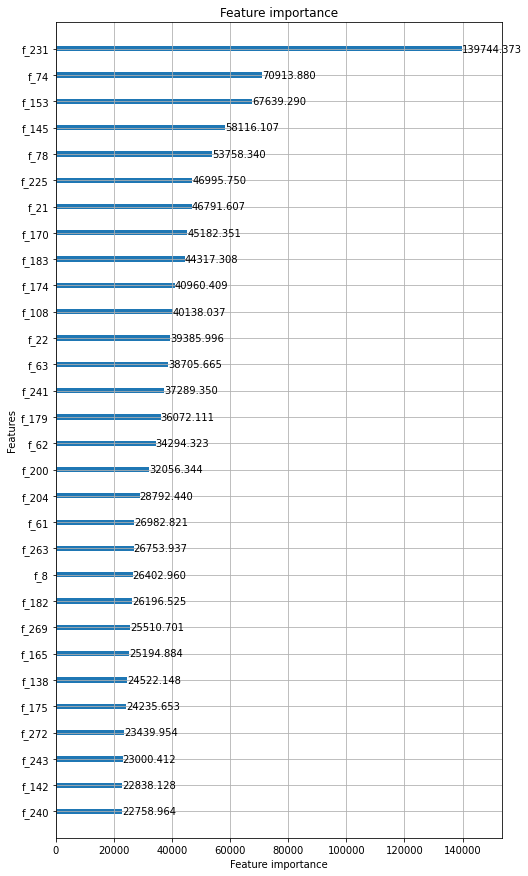

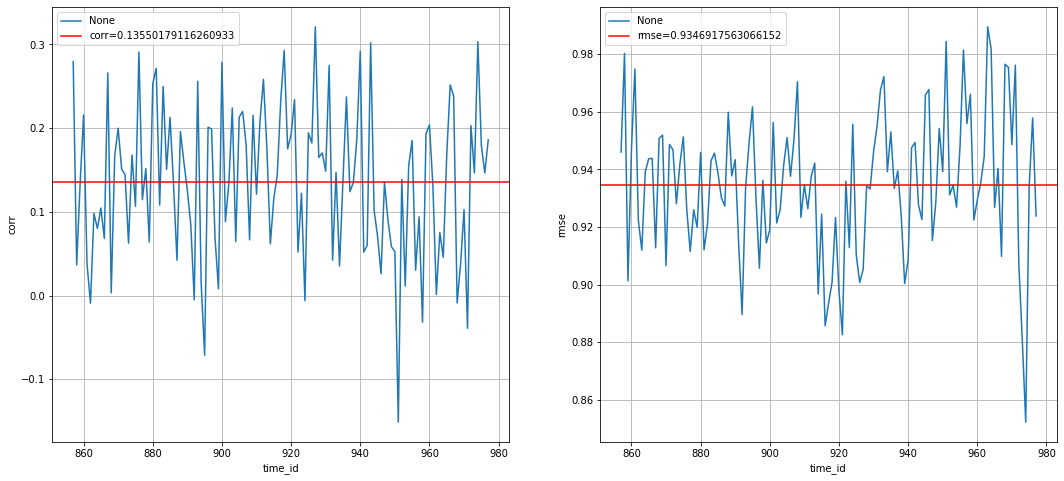

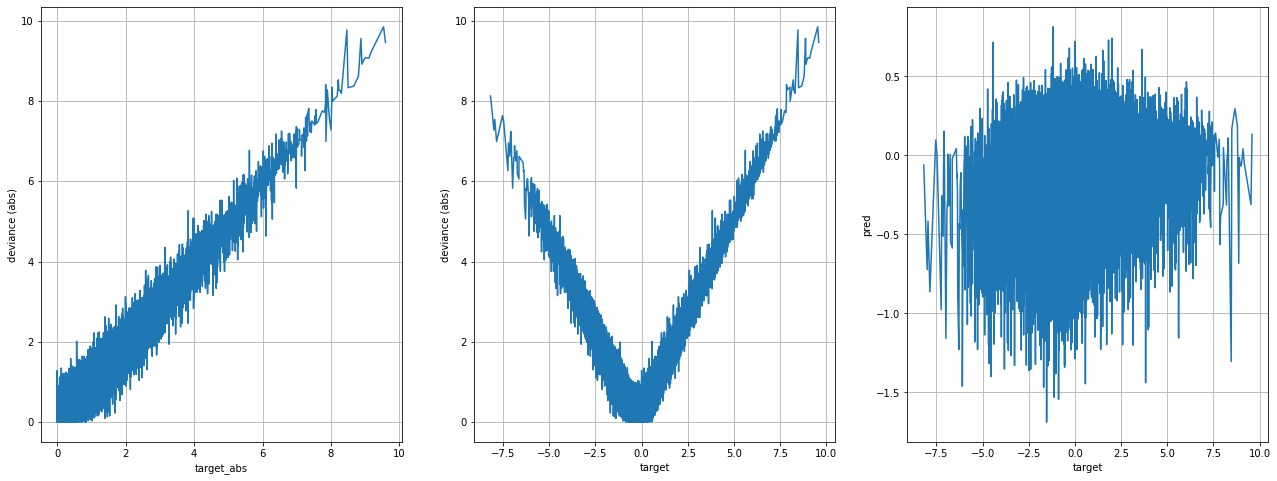

n_iterations: 0


In [12]:
pretrain = True

if pretrain:
    
    models = list()

    for train_idx,valid_idx in splits:

        train_dset = lgb.Dataset(
            data=features.loc[train_idx,:],
            label=target.loc[train_idx,"target"].values,
            free_raw_data=True
        )
        valid_dset = lgb.Dataset(
            data=features.loc[valid_idx,:],
            label=target.loc[valid_idx,"target"].values,
            free_raw_data=True
        )

        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            num_boost_round=1000,
            valid_sets=[valid_dset,],
            early_stopping_rounds=50,
            verbose_eval=20,
            feval=pearsonr,
        )
        models.append(model)

        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()
        
        # residual analysis on oof predictions
        oof = target.loc[valid_idx,:].copy()
        oof["time_id"] = time.loc[valid_idx,"time_id"]
        oof["pred"] = model.predict(features.loc[valid_idx,:])
        oof["target_abs"] = oof.eval("abs(target)")
        oof["dev"] = oof.eval("abs(target-pred)")

        corrs = oof.groupby("time_id").apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
        corr_mean = corrs.mean()
        error = oof.groupby("time_id").apply(lambda x: np.sqrt(np.mean((x.target-x.pred)**2)))
        error_mean = error.mean()

        plt.figure(figsize=(18,8))
        plt.subplot(1,2,1)
        corrs.plot()
        plt.axhline(y=corr_mean, color='r', linestyle='-', label=f"corr={corr_mean}")
        plt.grid()
        plt.ylabel("corr")
        plt.legend(loc="best")
        ##
        plt.subplot(1,2,2)
        error.plot()
        plt.axhline(y=error_mean, color='r', linestyle='-', label=f"rmse={error_mean}")
        plt.grid()
        plt.ylabel("rmse")
        plt.legend(loc="best")
        plt.show()

        plt.figure(figsize=(22,8))
        ##
        plt.subplot(1,3,1)
        plt.plot(oof.sort_values("target_abs").target_abs.values, oof.sort_values("target_abs").dev.values)
        plt.xlabel("target_abs")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,2)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").dev.values)
        plt.xlabel("target")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,3)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").pred.values)
        plt.xlabel("target")
        plt.ylabel("pred")
        plt.grid()
        plt.show()
           
    n_iterations = int(np.mean([m.best_iteration for m in models]))
    
else:
    # best value previously found
    n_iterations = 546
    

print("n_iterations:", n_iterations)

***
## model training

In [ ]:
seeds = [2,7,11,19,23]
models = list()

for seed in seeds:
    model_params["seed"] = seed
    
    train_dset = lgb.Dataset(
        data=features,
        label=target.target.values,
        free_raw_data=True
    )
    #random_idx = train.sample(frac=0.2).index
    #valid_dset = lgb.Dataset(
    #    data=train.loc[random_idx,features],
    #    label=train.loc[random_idx,"target"].values,
    #    free_raw_data=True
    #)
    model = lgb.train(
        params=model_params,
        train_set=train_dset,
        num_boost_round=n_iterations,
        valid_sets=[train_dset,],
        early_stopping_rounds=10*n_iterations,
        verbose_eval=20,
        feval=pearsonr,
    )
    models.append(model)

    lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
    lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
    plt.show()

In [ ]:
for seed,model in zip(seeds,models): 
    model.save_model(f"lgbm-seed{seed}.txt")

***
## inference

In [ ]:
import ubiquant
env = ubiquant.make_env()  
iter_test = env.iter_test()

In [ ]:
features = [f"f_{i}" for i in range(300)]

for (test_df, sample_prediction_df) in iter_test:  
    preds = [model.predict(test_df[features]) for model in models]
    sample_prediction_df['target'] = np.mean(preds, axis=0)
    env.predict(sample_prediction_df) 
    display(sample_prediction_df)

***